In [1]:
# Imports

import os
import random
import skimage
import imageio
import skimage.transform
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
# Function to load data

def load_data(data_dir):

    dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    labels = []
    images = []

    for d in dirs:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, fn) for fn in os.listdir(label_dir) if fn.endswith(".ppm")]

        for fn in file_names:
            images.append(imageio.v2.imread(fn))
            labels.append(int(d))

    return images, labels


ROOT_PATH = os.getcwd()
train_dir = os.path.join(ROOT_PATH, "TrainingData")
test_dir = os.path.join(ROOT_PATH, "Testing")

images, labels = load_data(train_dir)

print(f"Labels: {len(set(labels))}, Images: {len(images)}")

Labels: 62, Images: 4575


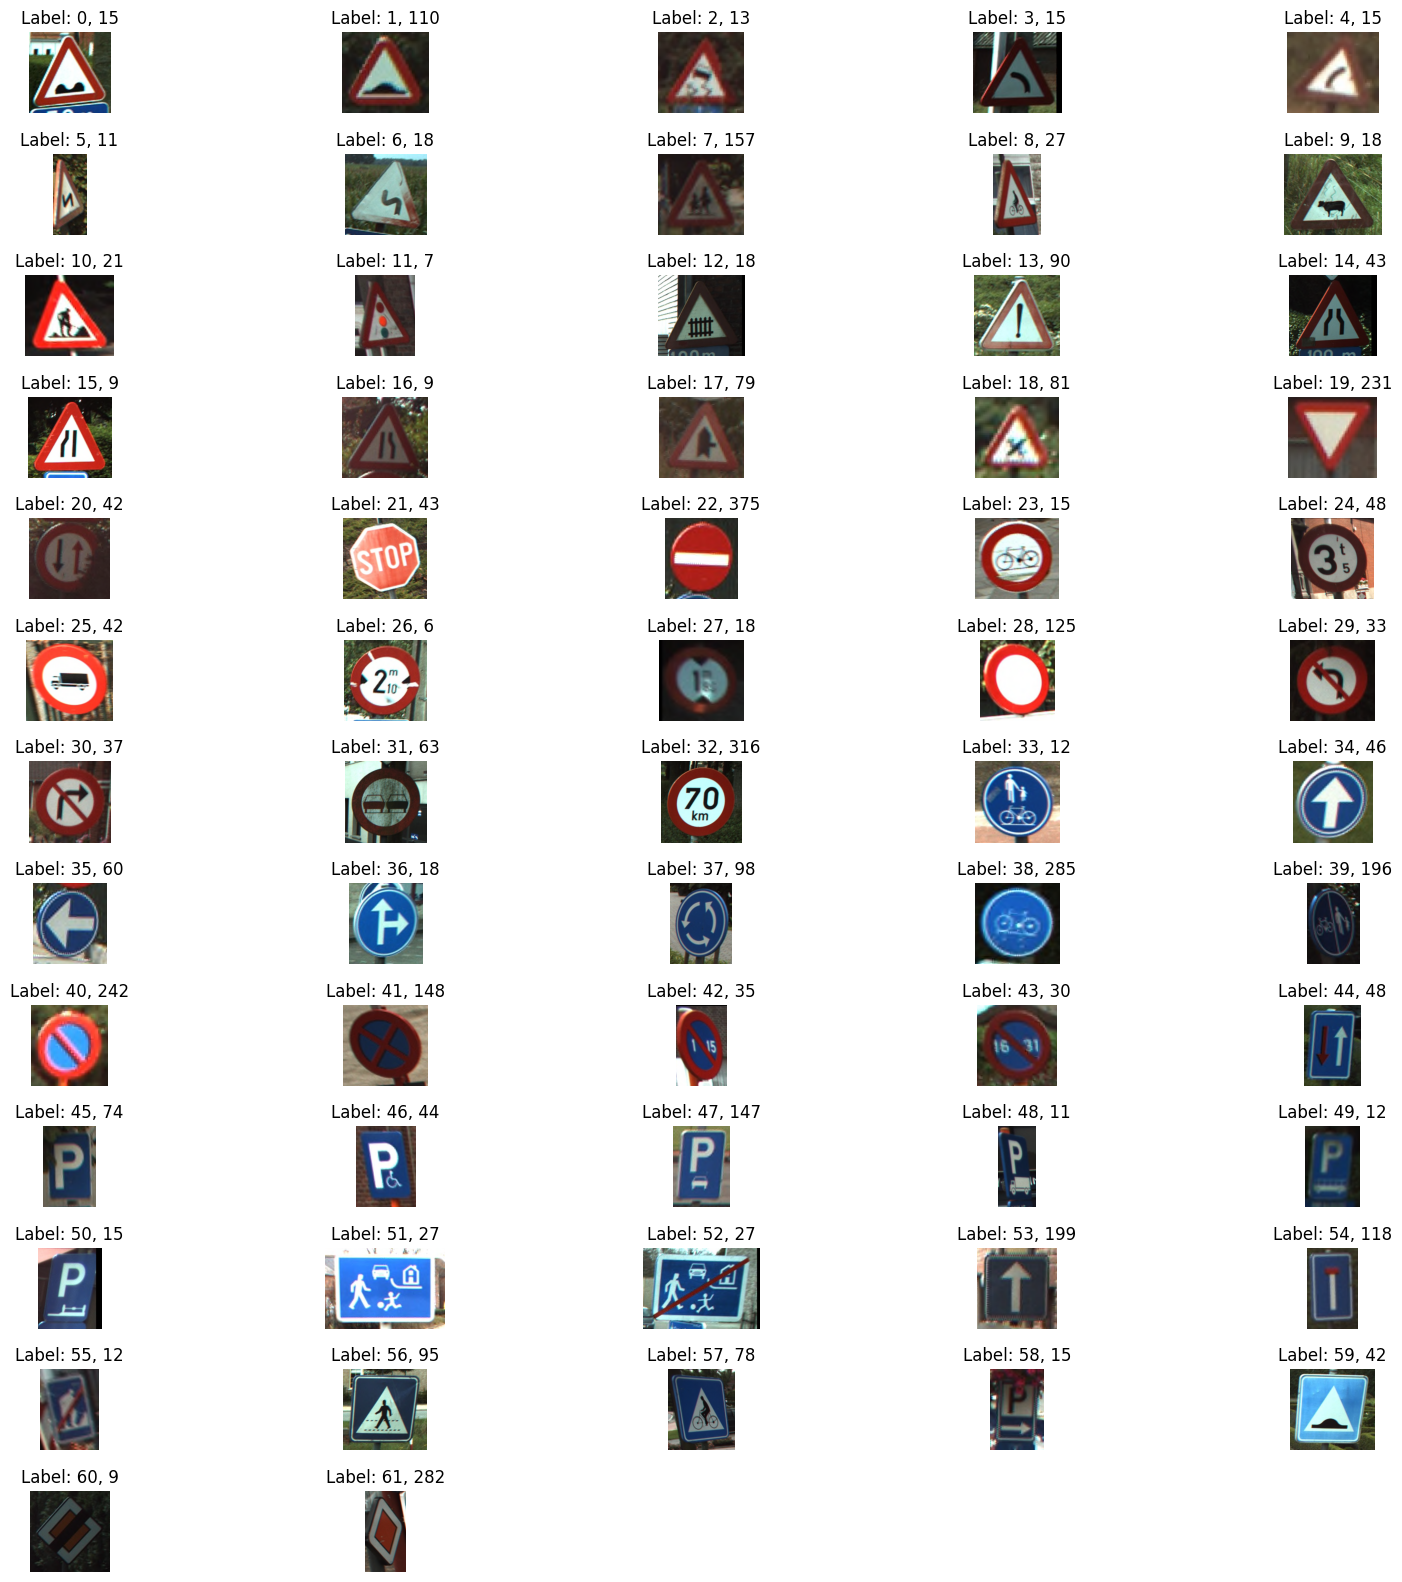

In [3]:
def show_img_and_labels(images, labels):
    unique_labels = set(labels)
    n = len(unique_labels)
    rows = (n // 5) + 1
    plt.figure(figsize=(20, 20))
    plt.subplots_adjust(hspace=0.5, wspace=0.1)
    i = 1

    for label in unique_labels:
        img = images[labels.index(label)]
        plt.subplot(rows, 5, i)
        plt.axis("off")
        plt.title(f"Label: {label}, {labels.count(label)}")
        i += 1
        _ = plt.imshow(img)
    plt.show()

show_img_and_labels(images, labels)

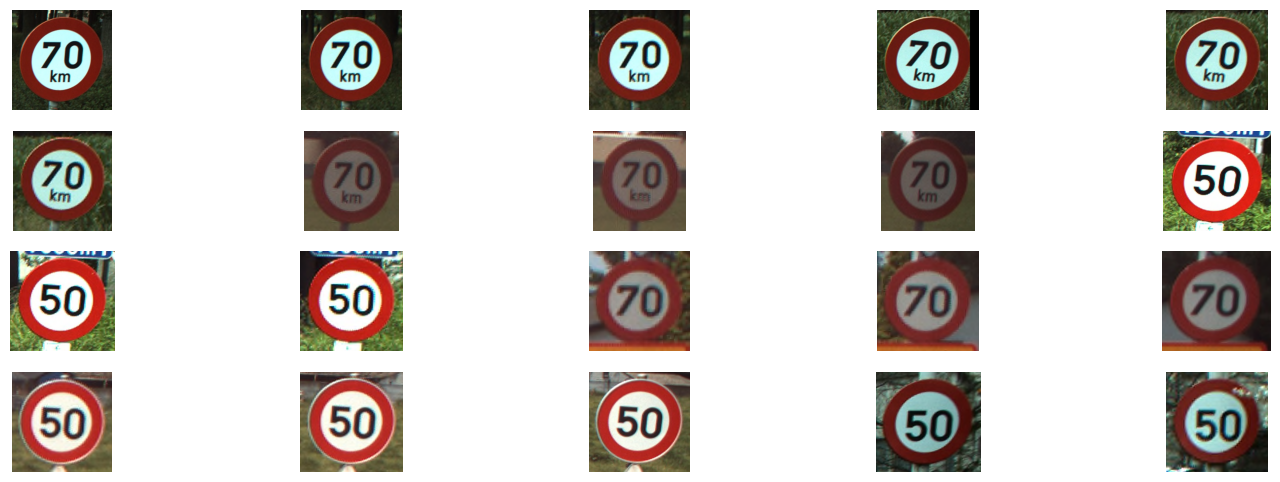

In [4]:
def show_label_imgs(images, label):
    edge = 20
    plt.figure(figsize=(18, 6))
    start = labels.index(label)
    end = start + labels.count(label)
    i = 1

    for image in images[start:end][:edge]:
        plt.subplot(4, 5, i)
        plt.axis("off")
        i += 1
        plt.imshow(image)
    plt.show()

show_label_imgs(images, 32)

In [5]:
# Lets see the shape of our images

for image in images[:10]:
    print(f"Shape: {image.shape}, min: {image.min()}, max: {image.max()}")

Shape: (141, 142, 3), min: 0, max: 255
Shape: (120, 123, 3), min: 0, max: 255
Shape: (105, 107, 3), min: 0, max: 255
Shape: (94, 105, 3), min: 7, max: 255
Shape: (128, 139, 3), min: 0, max: 255
Shape: (110, 118, 3), min: 8, max: 255
Shape: (85, 95, 3), min: 0, max: 255
Shape: (180, 193, 3), min: 0, max: 255
Shape: (121, 133, 3), min: 0, max: 255
Shape: (81, 88, 3), min: 10, max: 255


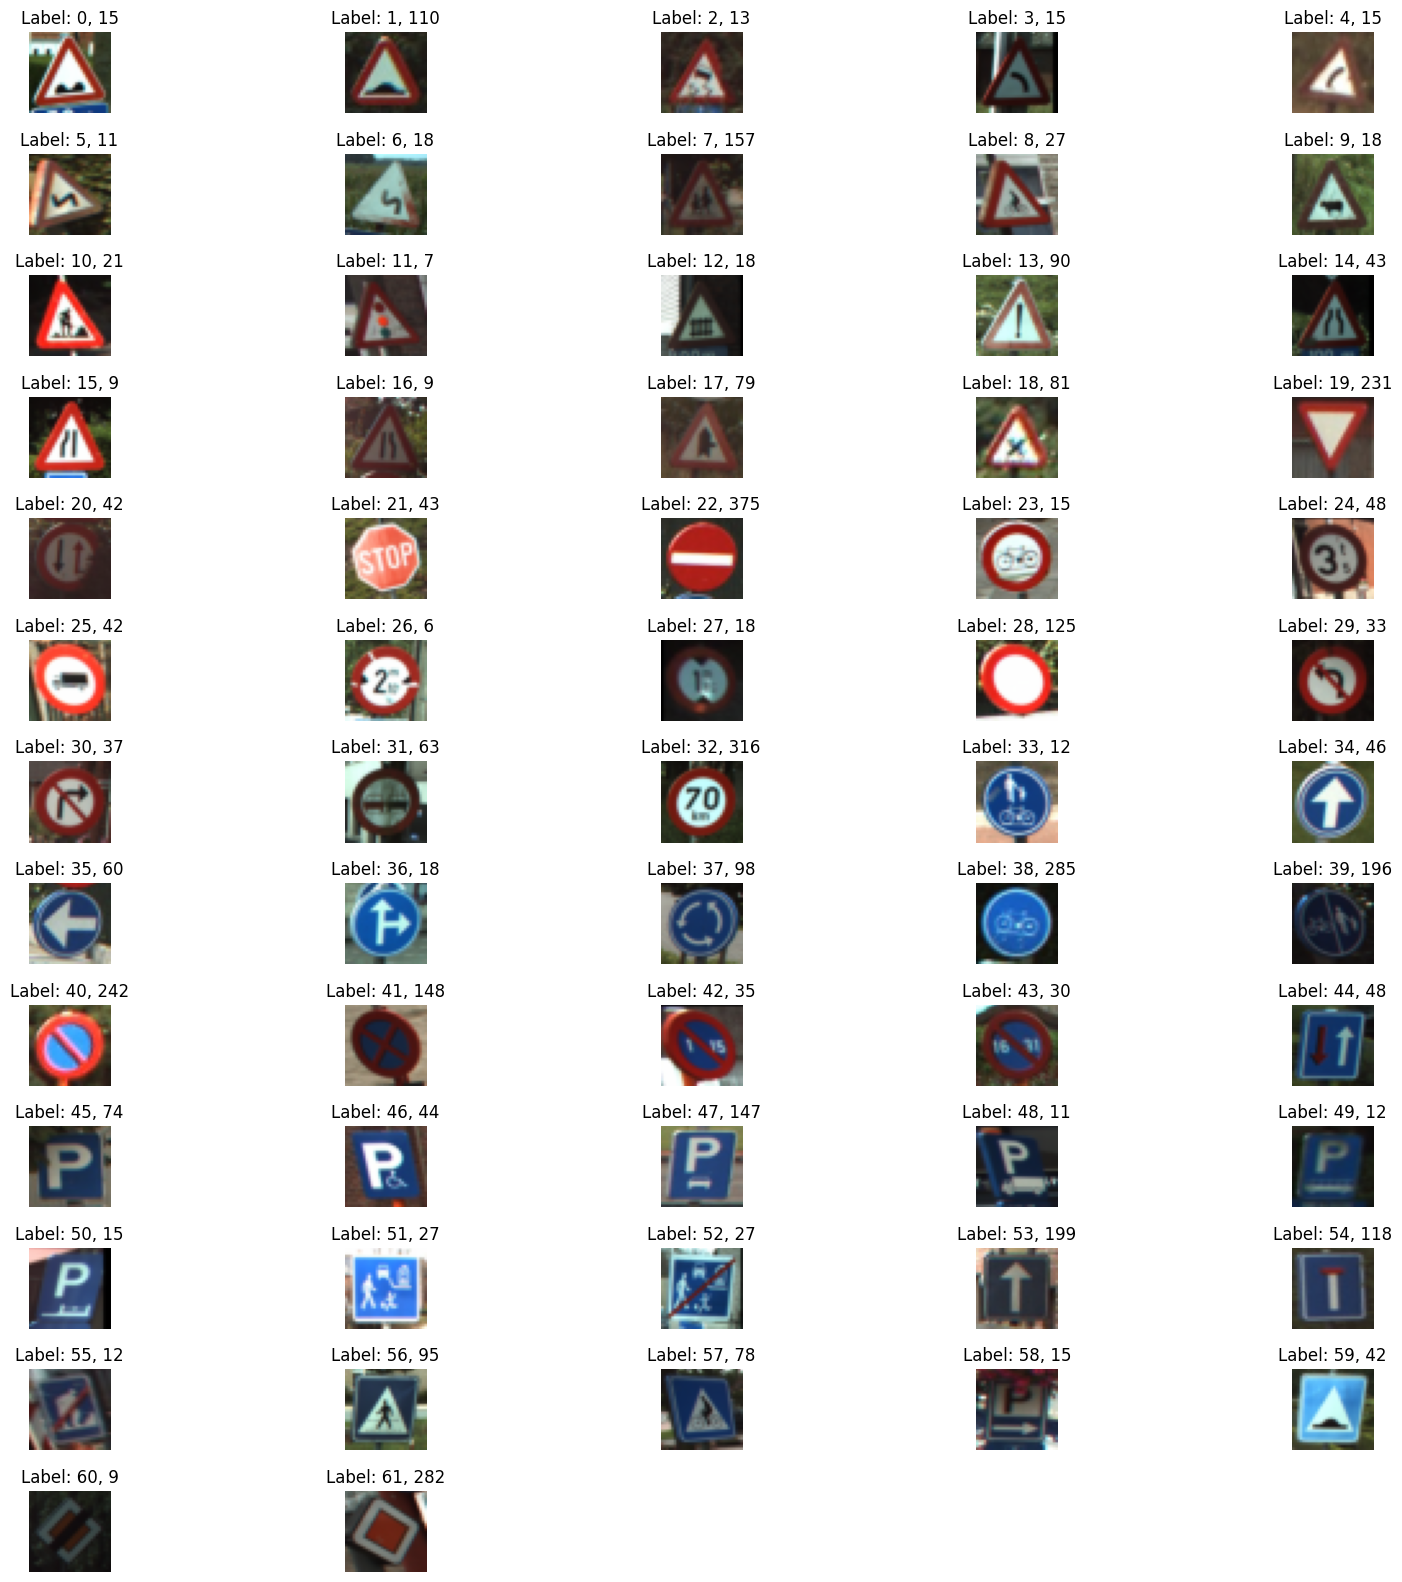

Shape: (32, 32, 3), min: 0.0408831123942043, max: 0.9998171781334138
Shape: (32, 32, 3), min: 0.03833391811044041, max: 0.9999986658947251
Shape: (32, 32, 3), min: 0.04162877876121437, max: 0.9999971795462242
Shape: (32, 32, 3), min: 0.06842239211304987, max: 0.9235668331529523
Shape: (32, 32, 3), min: 0.06414078391391745, max: 0.9062750385650252
Shape: (32, 32, 3), min: 0.07603053560443873, max: 0.9316718369080721
Shape: (32, 32, 3), min: 0.043308033686355565, max: 0.9654574723790361
Shape: (32, 32, 3), min: 0.008829292765623411, max: 0.878587162877027
Shape: (32, 32, 3), min: 0.05767028427413825, max: 0.9982131684955731
Shape: (32, 32, 3), min: 0.08962891224185526, max: 0.9999995140005334


In [6]:
# let's resize the shape and see the result

resized_imgs = [skimage.transform.resize(image, (32, 32)) for image in images]
show_img_and_labels(resized_imgs, labels)

for image in resized_imgs[:10]:
    print(f"Shape: {image.shape}, min: {image.min()}, max: {image.max()}")

In [7]:
labels_a = np.array(labels)
images_a = np.array(resized_imgs)
unique = (np.unique(labels_a))
print(f"Labels: {labels_a.shape}, Images: {images_a.shape}")

Labels: (4575,), Images: (4575, 32, 32, 3)


In [ ]:
# Let's create the model

model = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation=None, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation=None, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3,3), activation=None, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(420, activation=None, kernel_regularizer=regularizers.l2(0.04)),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),
    Dense(264, activation=None, kernel_regularizer=regularizers.l2(0.04)),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.2),
    Dense(62, activation="softmax")
])

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 410)            │       840,090 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 410)            │         1,640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 410)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 410)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 260)            │       106,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 260)            │         1,040 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 260)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 260)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 62)             │        16,182 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,059,956 (4.04 MB)

 Trainable params: 1,058,168 (4.04 MB)

 Non-trainable params: 1,788 (6.98 KB)

In [24]:
# Data augmentation

images_a, labels_a = shuffle(images_a, labels_a, random_state=42)

datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.25,
                             height_shift_range=0.25,
                             shear_range=0.25,
                             zoom_range=0.25,
                             horizontal_flip=True,
                             validation_split=0.2,
                             fill_mode='nearest')

datagen.fit(images_a)

train_gen = datagen.flow(images_a, labels_a, batch_size=64, subset='training')
val_gen = datagen.flow(images_a, labels_a, batch_size=64, subset='validation')

In [25]:
optim = Adam(learning_rate=0.0001)
model.compile(optimizer=optim,
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
hist = model.fit(
    train_gen,  
    epochs=400,
    validation_data=val_gen,
    callbacks=[reduce_lr]
)

Epoch 1/400


f:\tensorflow\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.0381 - loss: 43.1855 - val_accuracy: 0.0885 - val_loss: 39.2079 - learning_rate: 1.0000e-04
Epoch 2/400
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.1827 - loss: 37.5099 - val_accuracy: 0.0885 - val_loss: 34.5449 - learning_rate: 1.0000e-04
Epoch 3/400
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.2560 - loss: 32.7411 - val_accuracy: 0.0798 - val_loss: 30.3961 - learning_rate: 1.0000e-04
Epoch 4/400
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.2974 - loss: 28.5758 - val_accuracy: 0.0885 - val_loss: 26.7495 - learning_rate: 1.0000e-04
Epoch 5/400
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.3359 - loss: 24.9642 - val_accuracy: 0.1005 - val_loss: 23.5631 - learning_rate: 1.0000e-04
Epoch 6/400
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.3533 - loss: 21.8759 - val_accuracy: 0.1443 - val_loss: 20.7404 - learning_rate: 1.0000e-04
Epoch 7/400
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accur

In [13]:
# Loading and reshaping test data

test_images, test_labels = load_data(test_dir)

test_images_resized = [skimage.transform.resize(image, (32, 32)) for image in test_images]


In [26]:
# Converting to numpy array and evaluating the model

labels_b = np.array(test_labels)
images_b = np.array(test_images_resized)
print(f"Labels: {labels_b.shape}, Images: {images_b.shape}")

test_loss, test_acc = model.evaluate(images_b, labels_b)
print(f"Test loss: {test_loss:.9f}")
print(f"Test acc: {test_acc * 100:.2f}%")

Labels: (2520,), Images: (2520, 32, 32, 3)
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9206 - loss: 0.4189
Test loss: 0.368338078
Test acc: 94.40%


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


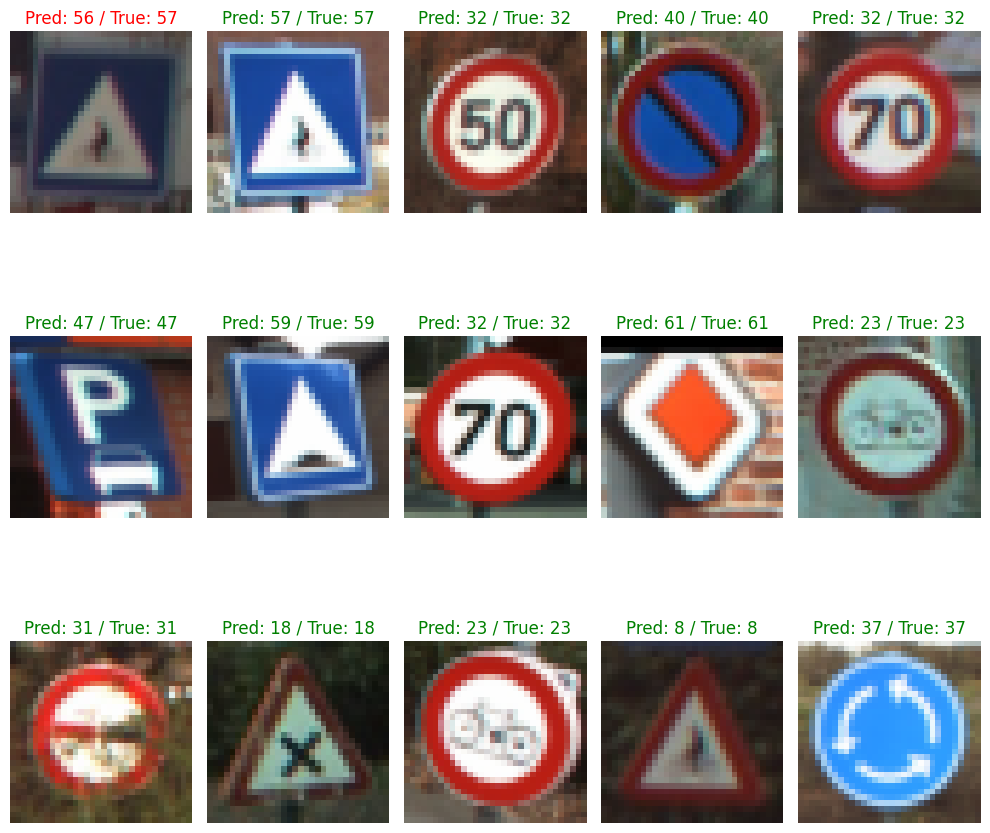

In [27]:

preds = model.predict(images_b)

pred_labels = np.argmax(preds, axis=1)

sample_idxs = random.sample(range(len(labels_b)), 15)


fig, axes = plt.subplots(3, 5, figsize=(10, 10))

for i, ax in zip(sample_idxs, axes.ravel()):
    ax.imshow(images_b[i])

    prediction = np.argmax(preds[i])
    true_class = labels_b[i]

    if prediction == true_class:
        ax.set_title(f"Pred: {prediction} / True: {true_class}", color='green')
    else:
        ax.set_title(f"Pred: {prediction} / True: {true_class}", color='red')
        

    ax.axis("off")

plt.tight_layout()
plt.show()

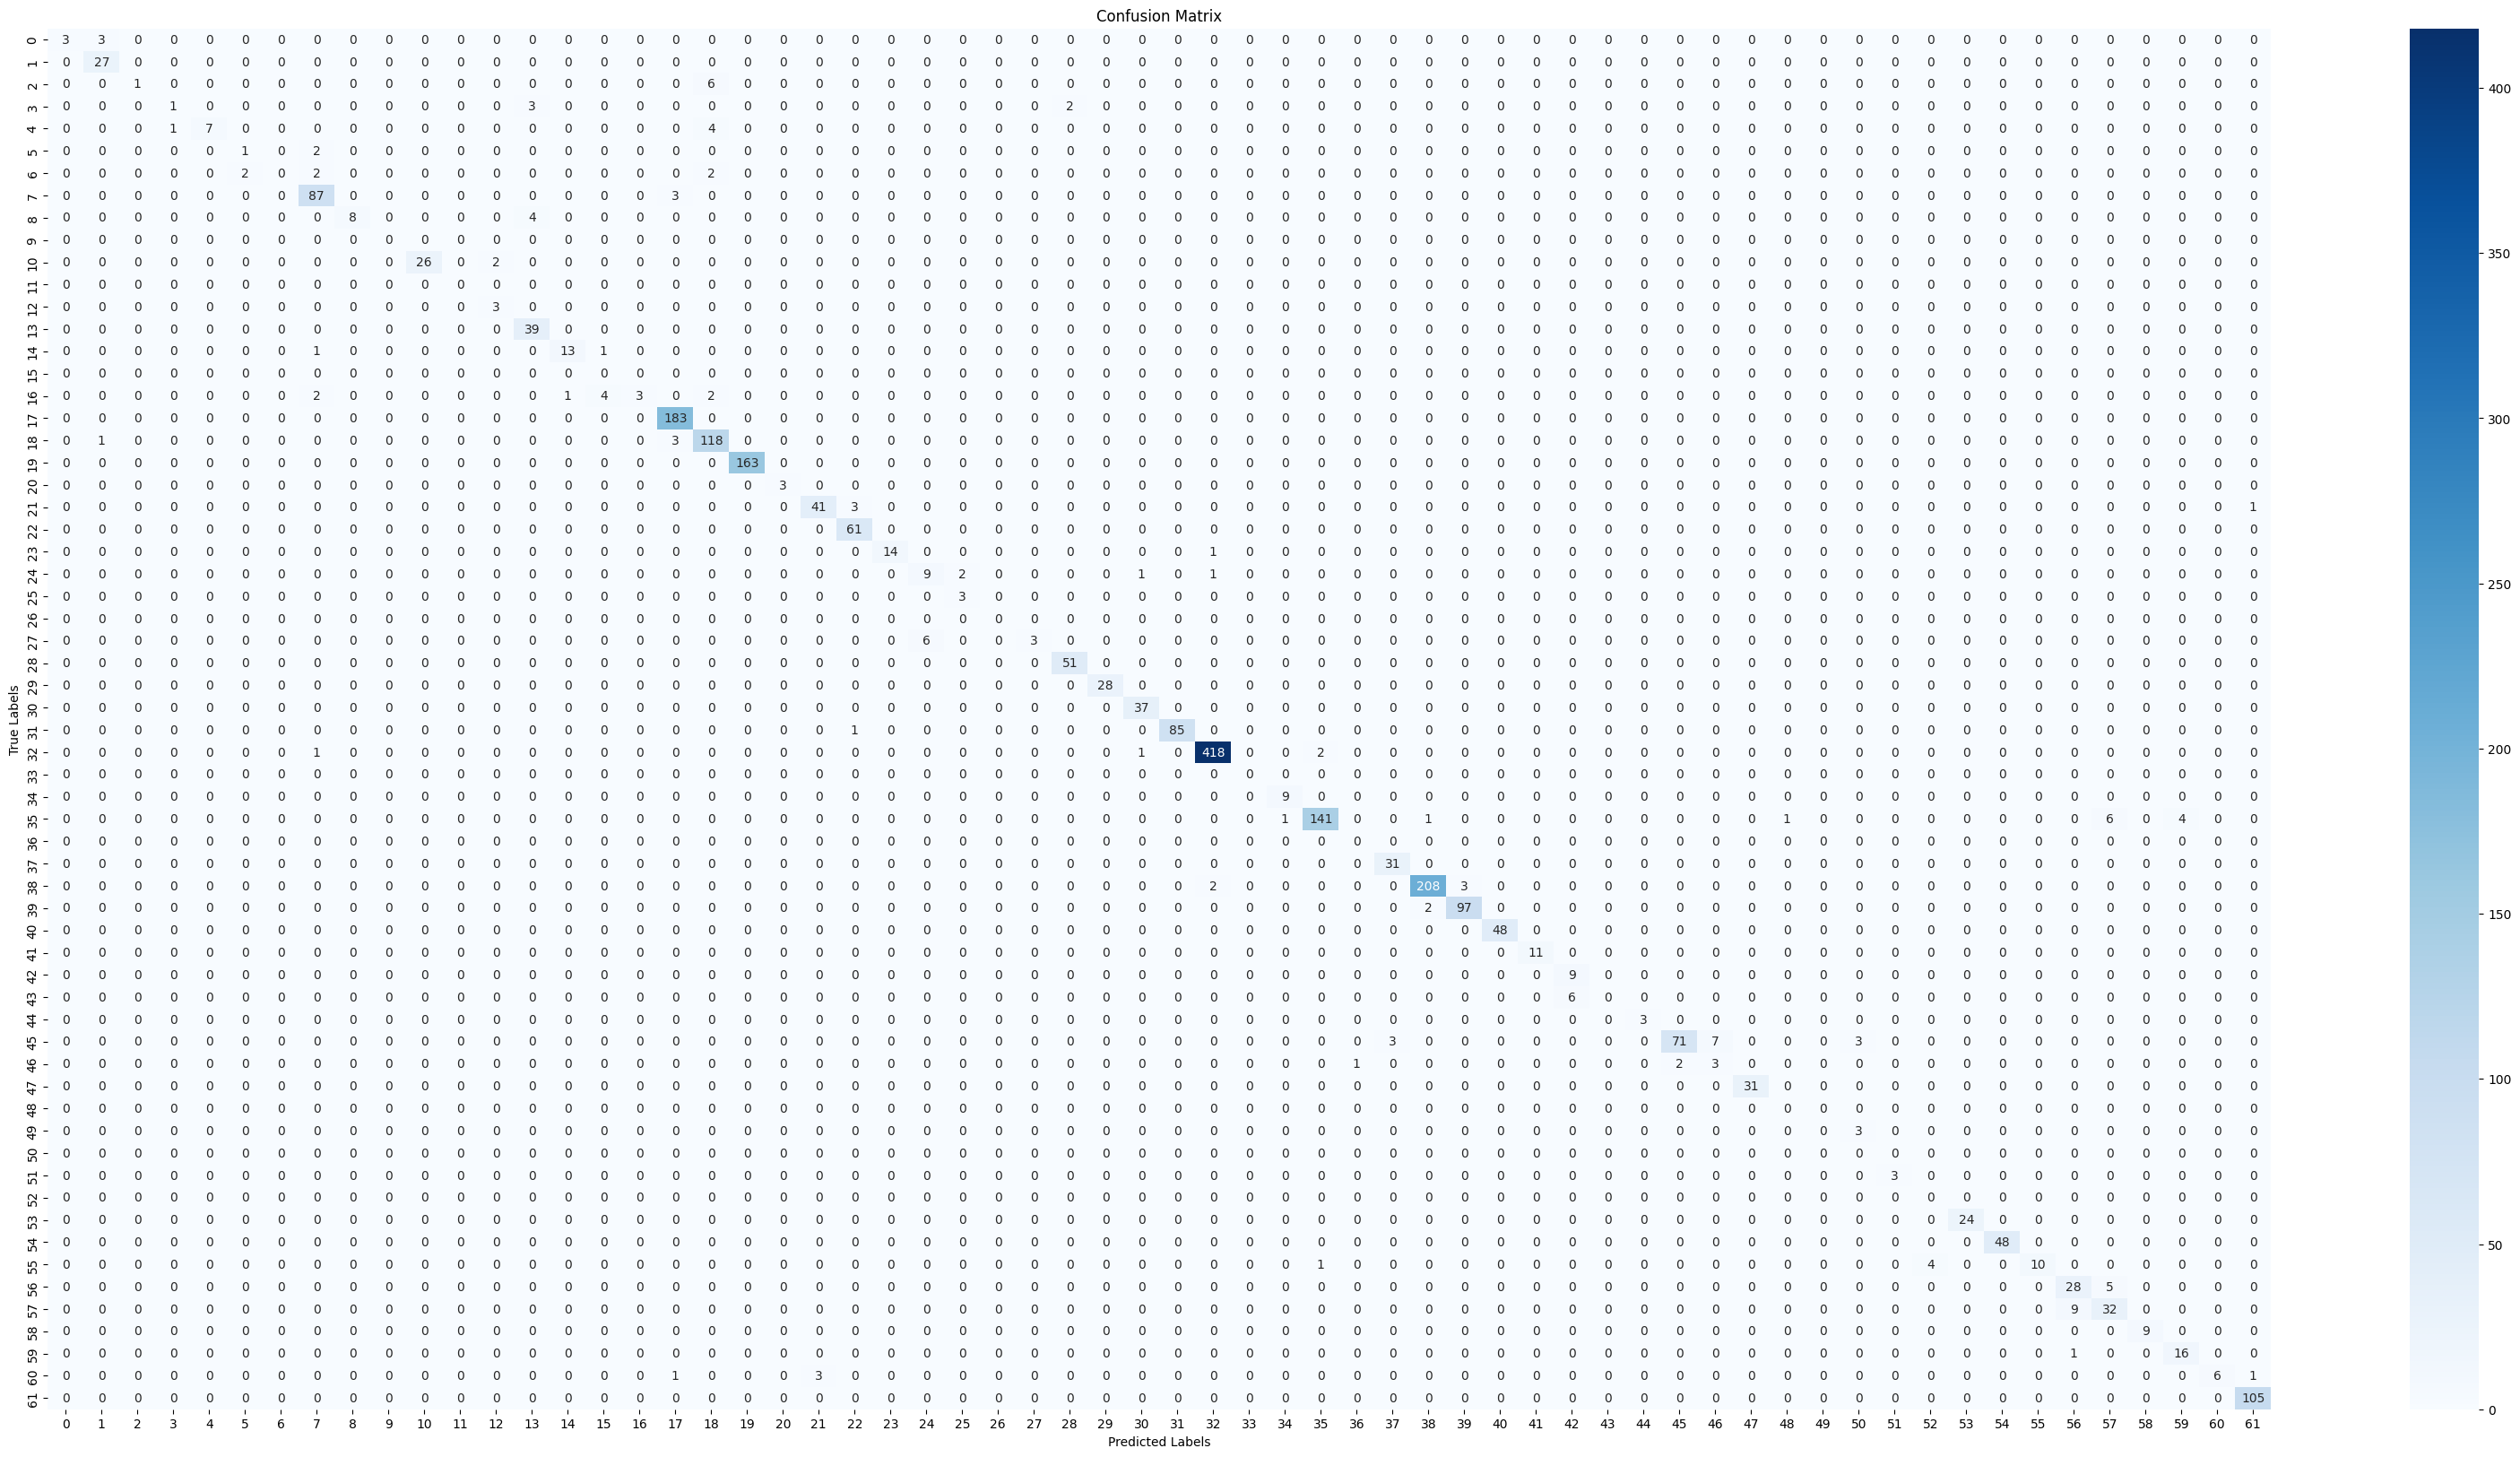

In [28]:
conf_matrix = confusion_matrix(labels_b, pred_labels, labels=np.arange(62))



plt.figure(figsize=(40, 20))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.arange(62), yticklabels=np.arange(62))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:
model.save('modelv1.keras')